# 第13章 発展編② 機械学習によるマイクロバイオームと機能未知遺伝子の解析
メタゲノム・対偶遺伝学・近傍遺伝子解析
- 西村 祐貴（東京大学 大学院新領域創成科学研究科 先端生命科学専攻）
- 綿野 桂人（東京大学 大学院理学系研究科 生物科学専攻）
- 岩崎 渉（東京大学 大学院新領域創成科学研究科 先端生命科学専攻、東京大学 大学院理学系研究科 生物科学専攻、東京大学 大学院新領域創成科学研究科 メディカル情報生命専攻、東京大学 大気海洋研究所、東京大学 定量生命科学研究所、東京大学 微生物科学イノベーション連携研究機構）

編集部注：「入力13-2」までのコードを書籍掲載のものから修正いたしました

In [1]:
%%bash --out stdout --err stderr
tar jxvf microbiome_suppl.tar.bz2

##### 入力13-1

In [2]:
%%bash --out stdout --err stderr
# %%bashから始まる行を実行するとセル内のコードがすべてシェルスクリプトとして処理される
pip3 install pyqt5==5.14.0
# setup conda
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py310_23.1.0-1-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

# other tools
conda install -c conda-forge -y mamba
mamba env update -f microbiome_suppl/base.yml 2>/dev/null

In [3]:
%%bash --out stdout --err stderr
python -m venv myenv
source myenv/bin/activate
pip install ete3
pip install ete3 --upgrade

mkdir user_results
wget https://data.gtdb.ecogenomic.org/releases/release207/207.0/bac120_metadata_r207.tar.gz
tar -xvf bac120_metadata_r207.tar.gz

##### 入力13-2（以下のコードの実行方法は図13.1を参照）

```
mkdir fastq; cd fastq

for id in ERR011347 ERR011348 ERR011349
do
wget ftp.sra.ebi.ac.uk/vol1/fastq/ERR011/${id}/${id}_1.fastq.gz
wget ftp.sra.ebi.ac.uk/vol1/fastq/ERR011/${id}/${id}_2.fastq.gz
done

ls *_1.fastq.gz | sed 's/_1.fastq.gz//g' | xargs -I@ \
fastp -i @_1.fastq.gz -I @_2.fastq.gz -o @_trimmed1.fastq.gz \
-O @_trimmed2.fastq.gz -f 5 -F 5 --html @.html -w 10

cat *_trimmed1.fastq.gz > all_1.fq.gz
cat *_trimmed2.fastq.gz > all_2.fq.gz

cd ..
```

##### 入力13-3（以下のコードの実行方法は図13.1を参照）

```
# setup eggNOG-mapper
mkdir eggnog-mapper-data; export EGGNOG_DATA_DIR=$(pwd)/eggnog-mapper-data
download_eggnog_data.py

# setup GTDB-Tk
conda create -n gtdbtk -y -c bioconda gtdbtk
activate gtdbtk
export GTDBTK_DATA_PATH=$(pwd)
download-db.sh
conda deactivate
```

##### 入力13-4

In [4]:
import sys
sys.path.append('myenv/lib/python3.10/site-packages')
import os, shutil
import numpy as np
import pandas as pd
import ete3 as et
import networkx as nx
from collections import Counter
from itertools import combinations
from scipy.stats import brunnermunzel
from statsmodels.stats.multitest import multipletests
from ete3.treeview.main import TreeStyle
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

/content/myenv/lib/python3.10/site-packages/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if line is '\n':


##### 入力13-5（以下のコードの実行方法は図13.1を参照）

```
megahit -1 fastq/all_1.fq.gz -2 fastq/all_2.fq.gz -o megahit_all -t 20 -m 0.8
cp megahit_all/final.contigs.fa user_results/final.contigs.fa
```

#### 入力13-6

In [5]:
if os.path.exists('user_results/final.contigs.fa'):
    contig = 'user_results/megahit_contig.fasta'
else:
    contig = 'microbiome_suppl/final.contigs.fa'
outfile = open('megahit_contig.fasta', encoding='utf-8', mode='w')
flag = 0
for line in open(contig, encoding='utf-8'):
    if line.startswith('>'):
        split = line.strip().split()
        length = split[-1].split('=')[1]
        if len(length) >= 4:
            coverage = split[-2].split('=')[1]
            seqname = split[0] + '_length_' + length + '_cov' + coverage + '\n'
            outfile.write(seqname)
            flag = 1
        else:
            flag = 0
    else:
        if flag == 1:
            outfile.write(line)

outfile.close()


##### 入力13-7（以下のコードの実行方法は図13.1を参照）

```
mkdir trimmed; mv fastq/*_trimmed1.fastq.gz trimmed; mv fastq/*_trimmed2.fastq.gz trimmed

coverm make -r megahit_contig.fasta --coupled trimmed/ERR* -o mapping -t 20 jgi_summarize_bam_contig_depths --outputDepth mb_depth.txt mapping/*.bam
metabat2 -i megahit_contig.fasta -a mb_depth.txt -o metabat2/metabat2 -t 20 cp megahit_contig.fasta.metabat-bins*/*.fa metabat2_bin/Fasta_to_Scaffolds2Bin.sh -i metabat2_bin/ -e fa > metabat2.contig2bin.tsv
cd trimmed; run_MaxBin.pl -contig ../megahit_contig.fasta -reads ERR011347_trimmed1.fastq.gz
-reads2 ERR011348_trimmed1.fastq.gz -reads3 ERR011349_trimmed1.fastq.gz -out maxbin2 -thread 20

cd ..; mkdir maxbin2_bin; mv trimmed/*.fasta maxbin2_bin
Fasta_to_Scaffolds2Bin.sh -i metabat2_bin/ -e fa > metabat2.contig2bin.tsv

DAS_Tool -i metabat2.contig2bin.tsv,maxbin2.contgi2bin.tsv -l \
metabat2,maxbin2 contig.fasta -t 20 -o dastool --search_engine diamond \
--score_threshold 0.1 --write_bins

mv dastool/dastool_DASTool_bins user_results/DAStool_bins
```

##### 入力13-8（以下のコードの実行方法は図13.1を参照）

```
mkdir checkm_database; checkm data setRoot checkm_database; cd checkm_database
wget https://data.ace.uq.edu.au/public/CheckM_databases/checkm_data_2015_01_16.tar.gz
tar zxvf checkm_data_2015_01_16.tar.gz; cd ..
if [ -d 'user_results/DAStool_bins' ]; then
    checkm lineage_wf -t 8 -x fa user_results/DAStool_bins checkM 1> checkM_log
else
    checkm lineage_wf -t 8 -x fa microbiome_suppl/DAStool_bins checkM 1> checkM_log
fi
checkm qa checkM/lineage.ms checkM/ > user_results/checkM_result.txt
```

##### 入力13-9


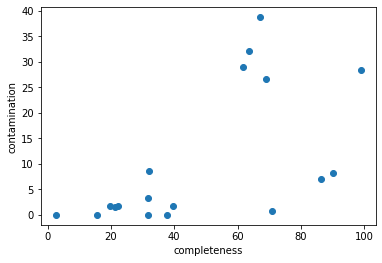

In [6]:
if not os.path.exists('user_results/checkM_result.txt'):
    df = pd.read_csv('microbiome_suppl/checkM_result.txt', skiprows=9, delim_whitespace=True, header=None)
else:
    df = pd.read_csv('user_results/checkM_result.txt', skiprows=9, delim_whitespace=True, header=None)
col = {0:'Bin_Id', 1:'Marker', 2:'Lineage', 3:'num_genomes', 4:'num_markers', 5:'num_marker_sets', 
       6:'0', 7:'1', 8:'2', 9:'3', 10:'4', 11:'5+', 12:'Completeness', 
       13:'Contamination', 14:'heterogeneity' }
df.rename(columns=col, inplace=True)
plt.xlabel('completeness')
plt.ylabel('contamination')
plt.scatter(df.Completeness, df.Contamination)

##### 入力13-10

In [7]:
if not os.path.exists('draft_mag'):
    os.mkdir('draft_mag')
if os.path.exists('user_results/DAStool_bins'):
    dastool_folder = 'user_results/DAStool_bins'
else:
    dastool_folder = 'microbiome_suppl/DAStool_bins'
for mag in df[df.Completeness >= 70].Bin_Id:
    shutil.copy(f'{dastool_folder}/{mag}.fa', 'draft_mag')

##### 入力13-11（以下のコードの実行方法は図13.1を参照）

```
conda activate gtdbtk
gtdbtk classify_wf --genome_dir draft_mag --cpus ${NCPUS} --out_dir user_GTDBtk -x fa --debug
conda deactivate
```

##### 入力13-12

In [8]:
if os.path.exists('user_GTDBtk'):
    bac_mag_info = pd.read_csv('user_GTDBtk/gtdbtk.bac120.summary.tsv', sep='\t')
else:
    bac_mag_info = pd.read_csv('microbiome_suppl/GTDBtk/gtdbtk.bac120.summary.tsv', sep='\t')
bac_mag_info.user_genome[1], bac_mag_info.classification.values[1]


('maxbin2.002',
 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Acutalibacteraceae;g__Ruminococcus_E;s__Ruminococcus_E bromii_B')

##### 入力13-13

<ipython-input-9-eb368edcd188>:2: DtypeWarning: Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.
  gtdb_meta = pd.read_csv('bac120_metadata_r207.tsv', sep='\t')


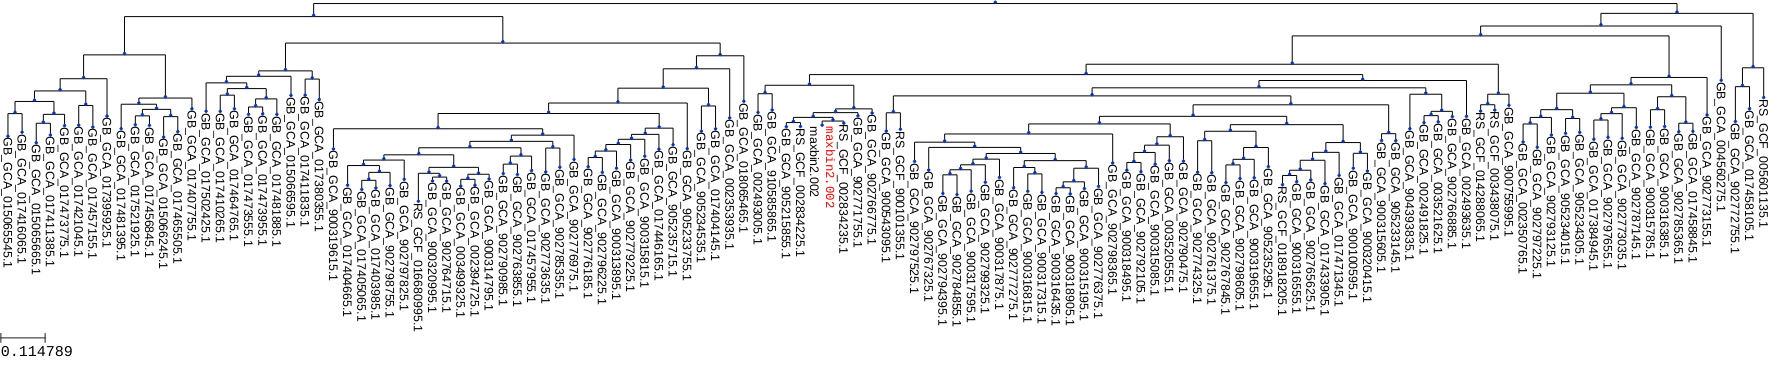

In [9]:
# メタデータから参照系統樹に含まれる代表種の情報を抜き出す
gtdb_meta = pd.read_csv('bac120_metadata_r207.tsv', sep='\t')
gtdb_meta = gtdb_meta[gtdb_meta.gtdb_representative == 't']

# maxbin2.002が所属するRuminococcus_Eのアクセッション番号を集める
# GTDB-Tkをローカルに実行した場合，binやgenusが異なる場合がある
target = bac_mag_info.user_genome[1]
target_genus = bac_mag_info.classification.values[1].split(';')[-2]
genomes_in_genus = gtdb_meta[gtdb_meta.gtdb_taxonomy.str.contains(target_genus)]
genomes_in_genus = list(genomes_in_genus.accession.values)
genomes_in_genus.append(target)

# 結果の系統樹を読み込んで，集めたアクセッション番号を含む部分だけを抽出
os.environ['QT_QPA_PLATFORM']='offscreen' # リモート環境の場合はコメントアウトを外す
if os.path.exists('user_GTDBtk'):
    gtdbtk_folder = 'user_GTDBtk/classify'
else:
    gtdbtk_folder = 'microbiome_suppl/GTDBtk/classify'
tree = et.Tree(f'{gtdbtk_folder}/gtdbtk.bac120.classify.tree.2.tree', 
               format=1, quoted_node_names=True)
tree.prune(genomes_in_genus)

ts = et.TreeStyle()
red_face = et.faces.AttrFace('name', fgcolor='Red')
def add_face(node):
    if node.is_leaf():
        if node.name == target:
            et.faces.add_face_to_node(red_face, node, column=0)

ts = et.TreeStyle()
ts.show_leaf_name = True
ts.rotation = 90
ts.layout_fn = add_face
tree.render('%%inline', w=500, units='mm', tree_style=ts)

##### 入力13-14（以下のコードの実行方法は図13.1を参照）

```
# GTDB-Tkを使ってフラボバクテリウム科のゲノムからマーカー遺伝子を抽出・アライメントする
# GTDB-Tkを実行するためには準備セクションのシェルスクリプトを使って，データベースをダウンロー ドしておく必要がある
conda activate gtdbtk
gtdbtk identify --genome_dir flavo_genome --out_dir user_gtdbtk_flavo -x fna --cpus 20 --debug
gtdbtk align --identify_dir user_gtdbtk_flavo/ --out_dir user_gtdbtk_flavo/ --cpus 20 --debug
gzip -d user_gtdbtk_flavo/align/gtdbtk.bac120.user_msa.fasta.gz
conda deactivate
```

##### 入力13-15（以下のコードの実行方法は図13.1を参照）

```
# アライメントから系統樹を推定する
if [ -d 'user_results/user_gtdbtk_flavo' ]; then
    trimal -in user_gtdbtk_flavo/align/gtdbtk.bac120.user_msa.fasta -out flavo_MSA.fasta -gt 0.9
else
    trimal -in microbiome_suppl/gtdbtk_flavo/align/gtdbtk.bac120.user_msa.fasta -out flavo_ MSA.fasta -gt 0.9
fi
iqtree2 -s flavo_MSA.fasta -m TEST -bb 1000 -nt 20
```

入力13-16

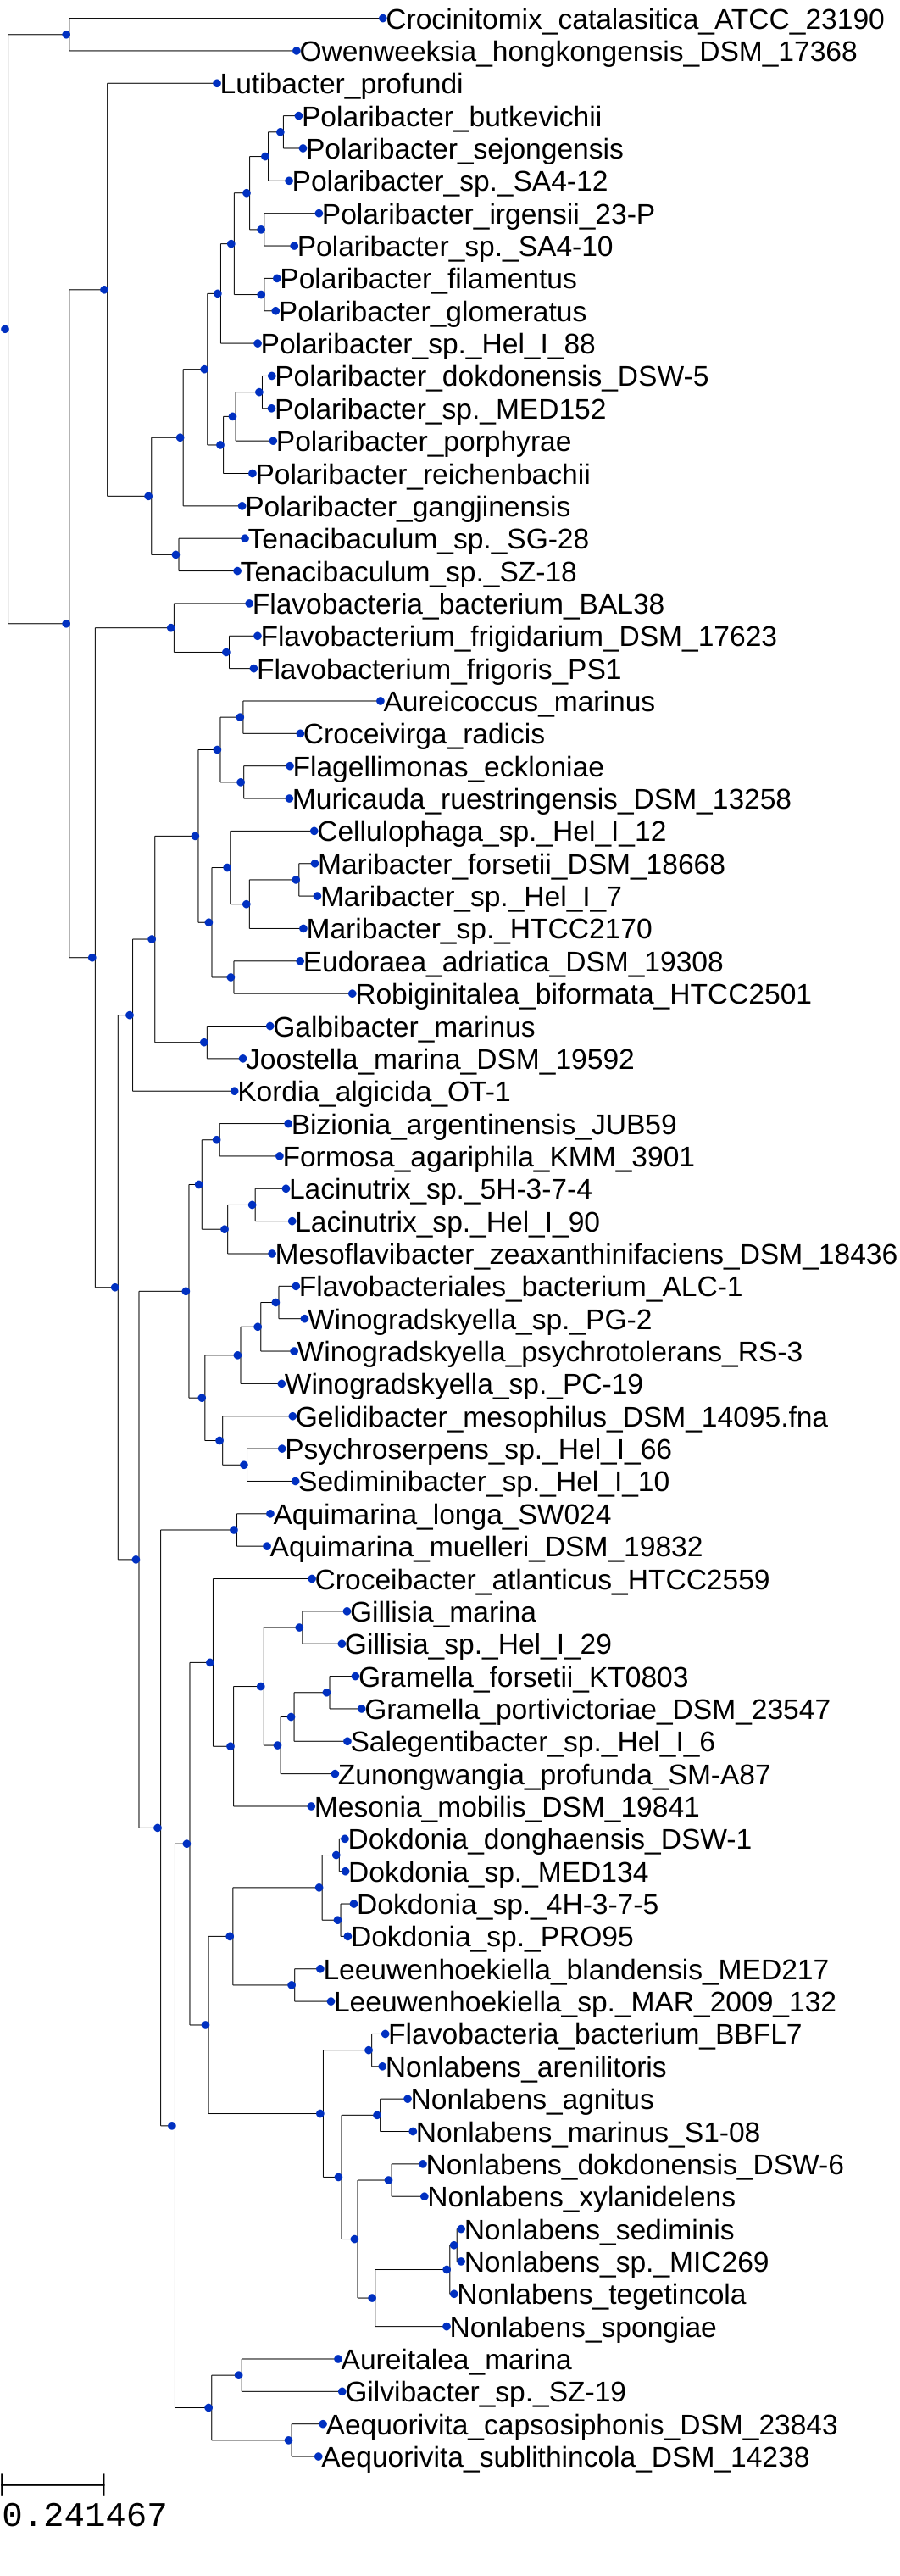

In [10]:
# 系統樹を読み込み，ルートの位置をKumagai et al.に合わせる
if os.path.exists('flavo_MSA.fasta.treefile'):
    flavo_tree = et.Tree('flavo_MSA.fasta.treefile')
else:
    flavo_tree = et.Tree('microbiome_suppl/flavo_MSA.fasta.treefile')
ancestor = flavo_tree.get_common_ancestor('g000053', 'g000011')
flavo_tree.set_outgroup(ancestor)

# 系統樹に種名の情報を追加する
genome_dict = { line.split()[0]:line.split()[1] 
               for line in open('microbiome_suppl/genome_list.txt')}
for leaf in flavo_tree.get_leaves():
    leaf.name = genome_dict[leaf.name]


# tree_styleは前のものを使いまわせる
flavo_tree.render('%%inline', w=300, units='mm')

##### 入力13-17

In [11]:
# GTDB-Tkの中間ファイルに，各ゲノムから予測されたタンパク質配列が含まれている
if not os.path.exists('flavo_input'):
    os.mkdir('flavo_input')
if os.path.exists('user_gtdbtk_flavo/identify/intermediate_results/marker_genes'):
    folder = 'user_gtdbtk_flavo/identify/intermediate_results/marker_genes'
else:
    folder = 'microbiome_suppl/gtdbtk_flavo/identify/intermediate_results/marker_genes'
for genome in os.listdir(folder):
    if os.path.exists(f'{folder}/{genome}/{genome}_protein.faa'):
        shutil.copy(f'{folder}/{genome}/{genome}_protein.faa', 
                    f'flavo_input/{genome}.faa')


##### 入力13-18（以下のコードの実行方法は図13.1を参照）

```
source sonicparanoid/bin/activate
sonicparanoid -i flavo_input -o user_flavo_output -t 20
deactivate
```

##### 入力13-19（以下のコードの実行方法は図13.1を参照）

```
# eggNOG-mapperを使うには準備セクションのシェルスクリプトを実行し，参照データベースをダウンロ ードしておく必要がある
cat flavo_input/*.fasta > all_genes # 解析するゲノムのタンパク質遺伝子をまとめて一度にアノテ ーションする
emapper.py -m diamond -i all_genes -o user_flavo_eggnog --cpu ${NCPUS}
```

##### 入力13-20

In [12]:
# eggNOG-mapperとSonicParanoidの結果を読み込む
if os.path.exists('user_flavo_eggnog.emapper.annotations'):
    annot_file = 'user_flavo_eggnog.emapper.annotations'
else:
    annot_file = 'microbiome_suppl/flavo_eggnog.emapper.annotations'
annot = pd.read_csv(annot_file, sep='\t', 
                    skiprows=4, # 最初の4行はアノテーションデータではないので飛ばす(行数はバージョンによって異なる場合がある)
                    index_col=['#query'] # 配列名をindexにしておくと何かと都合がよい
                    )
annot = annot.iloc[:-3] # 最後の3行もアノテーションデータではないので除く

# SonicParanoidの結果を読み込み，OGと遺伝子名だけのテーブルにする
if os.path.exists('user_flavo_output'):
    for folder in os.listdir('user_flavo_output/runs'):
        if folder.startswith('sonic'):
            table_path = f'user_flavo_output/runs/{folder}/ortholog_groups'
            break
else:
    table_path = 'microbiome_suppl/flavo_output/runs/sonic/ortholog_groups'

og_table = pd.read_csv(f'{table_path}/ortholog_groups.tsv', 
                       index_col='group_id', sep='\t')
og_table = og_table.iloc[:, 3::2]

# og_tableは1つのゲノムが1つのOGに対して複数の遺伝子を持っているとき，
# その配列名を , でつないで1つのセルに納めている
# そのままでは不便なことがあるので，遺伝子名とOGの対応をdictとしても保持しておく
seq_og = {} # 遺伝子名 -> OGのdict
og_seq = {} # OG -> set(遺伝子名)のdict
for i, row in og_table.iterrows():
    for sequences in row:
        if sequences != '*':
            for seq in sequences.split(','):
                seq_og[seq] = i
                og_seq.setdefault(i, set())
                og_seq[i].add(seq)

# アノテーションテーブルにOGの情報を追加する
og_annot = []
for seq in annot.index:
    if seq in seq_og:
        og_annot.append(seq_og[seq])
    else:
        og_annot.append('not_clustered')
annot.loc[:, 'OG'] = og_annot

# アノテーションがついたOG数を確認する
# まずアノテーションがつかなかった配列や，クラスタリングされなかった配列を除く
kegg = annot[(annot.KEGG_ko != '-') & (annot.OG != 'not_clustered') ]
pfam = annot[(annot.PFAMs != '-') & (annot.OG != 'not_clustered')]

# 多数決でOG -> KEGG IDとOG -> PFAMのdictを作る
# 1つの配列に複数のアノテーションがつく場合は
# 1つのカラムの中で複数のIDがコンマで連結されるので，やや煩雑な処理が必要
og_kegg = {}
og_pfam = {}
for og in set(kegg.OG):
    tmp = kegg[kegg.OG == og]
    kegg_ids = []
    for kos in tmp.KEGG_ko:
        kos = kos.split(',')
        kegg_ids.extend(kos)
    kegg_counter = Counter(kegg_ids)
    majority = kegg_counter.most_common()[0][0]
    og_kegg[og] = majority

for og in set(pfam.OG):
    tmp = pfam[pfam.OG == og]
    domains = []
    for dom in tmp.PFAMs:
        dom = dom.split(',')
        domains.extend(dom)
    domain_counter = Counter(domains)
    majority = domain_counter.most_common()[0][0]
    og_pfam[og] = majority

print(f'Number of OGs: {og_table.shape[0]}')
print(f'Number of KEGG assinged OGs: {len(og_kegg)}')
print(f'Number of PFAM assinged OGs: {len(og_pfam)}')

Number of OGs: 11558
Number of KEGG assinged OGs: 3461
Number of PFAM assinged OGs: 7557


##### 入力13-21

In [13]:
# アノテーション結果のDescription列にrhodopsinという文字列が含まれる配列名を取り出す
rh_annot = annot[annot.Description.str.contains('rhodopsin')]

# rhodopsinが含まれるOGと，その配列数を確認
rh_og = set()
non_clustered_rh = set()
for seq in rh_annot.index:
    if seq in seq_og:
        rh_og.add(seq_og[seq])
    else:
        non_clustered_rh.add(seq)

for og in rh_og:
    print(f'OG {og}: {len(og_seq[og])} sequences')
print(f'Number of non clustered Rhodopsin: {len(non_clustered_rh)}')

rh_annot.PFAMs.value_counts() # ドメインアノテーションの確認

OG 3953: 13 sequences
OG 2538: 33 sequences
Number of non clustered Rhodopsin: 0


Bac_rhodopsin    46
Name: PFAMs, dtype: int64

##### 入力13-22

In [14]:
annot[annot.PFAMs.str.contains('Bac_rhodopsin')].shape

(46, 21)

##### 入力13-23

In [15]:
# ロドプシンを持つゲノムを抽出
rh_plus = set()
for og in rh_og:
    rh_plus.update(og_table.T[og_table.loc[og] != '*'].index)

# ロドプシンを持たないゲノムを抽出
rh_minus = og_table.columns.difference(rh_plus)

# それぞれのゲノム数を確認
print(f'Genome with rhodopsin: {len(rh_plus)}')
print(f'Genome without rhodopsin: {len(rh_minus)}')

Genome with rhodopsin: 35
Genome without rhodopsin: 41


##### 入力13-24

In [16]:
# SonicParanoidの結果にはOGごと，ゲノムごとのコピー数が入ったtsvファイルも含まれている
count_table = pd.read_csv(f'{table_path}/ortholog_counts_per_species.stats.tsv', 
                          sep='\t', index_col='Group_ID')
count_table = count_table.iloc[:, :-1] # 最後の列は全ゲノムの合計数なので除く

# 全ゲノムでコピー数が同じOGは検定でエラーになるので除いておく
singleton = count_table[count_table.T.nunique() == 1]
count_table.drop(singleton.index, inplace=True)

# OGテーブルをRh+/-でわける
count_rh_plus = count_table.loc[:, rh_plus]
count_rh_minus = count_table.loc[:, rh_minus]

# 各OGについてBrunner-Munzel検定を行う
stat = []
pvalues = []
for i in range(count_rh_plus.shape[0]):
    plus = list(count_rh_plus.iloc[i])
    minus = list(count_rh_minus.iloc[i])

    # 各群のすべてのゲノムでコピー数が0のときはwarningが発生するので，1を加えておく
    if sum(plus) == 0:
        plus.append(1)
    if sum(minus) == 0:
        minus.append(1)

    test = brunnermunzel(plus, minus)
    stat.append(test.statistic)
    pvalues.append(test.pvalue)

# 多重検定補正
correction = multipletests(pvalues, method='fdr_bh')
contrapositive_og = count_table.loc[correction[0]].index

# 統計値の符号からどちらの群に多い遺伝子なのか判定できる
biased = {}
for og, value in zip(contrapositive_og, np.array(stat)[correction[0]]):
    if value > 0:
        biased[og] = '-'
    else:
        biased[og] = '+'

contrapositive_annot = annot[annot.OG.isin(contrapositive_og)].copy()
direction = [ biased[og] for og in contrapositive_annot.OG ]
contrapositive_annot.loc[:, 'biased'] = direction
contrapositive_annot.sort_values(by='OG', inplace=True)
contrapositive_annot.to_csv('contrapositive_annot.tsv', sep='\t')
Counter(biased.values())

<ipython-input-16-4d8602ebf933>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  count_rh_plus = count_table.loc[:, rh_plus]


Counter({'-': 47, '+': 31})

##### 入力13-25


In [17]:
# 対偶遺伝学的解析で抽出された78オルソロググループに含まれる遺伝子の配列名をまとめる
biased_sequences = set()
for og in contrapositive_og:
    biased_sequences.update(og_seq[og])

# コンティグ -> list(遺伝子ID)のdictを作る
seqs_by_contig = {}
for seq in biased_sequences:
    body = '_'.join(seq.split('_')[:-1])
    seq = int(seq.split('_')[-1])
    seqs_by_contig.setdefault(body, []).append(seq)

# 各コンティグ内で互いに近傍にある遺伝子を発見する
k = 10 # 近傍の定義
cluster_set = {} # コンティグ -> set(tuple(近傍遺伝子のID))
for key, value in seqs_by_contig.items():
    clusters = set()
    cluster = ()
    pre_num = sorted(value)[0] - 1
    for i in sorted(value):
        if i - pre_num <= k:
            cluster = cluster + (i,)
        else:
            if len(cluster) >= 2:
                clusters.add(cluster)
                cluster = (i,)
            else:
                cluster = (i,)
        pre_num = i
    if len(cluster) >= 2:
        clusters.add(cluster)
    if clusters:
        cluster_set[key] = clusters

##### 入力13-26

Largest connected component: 17


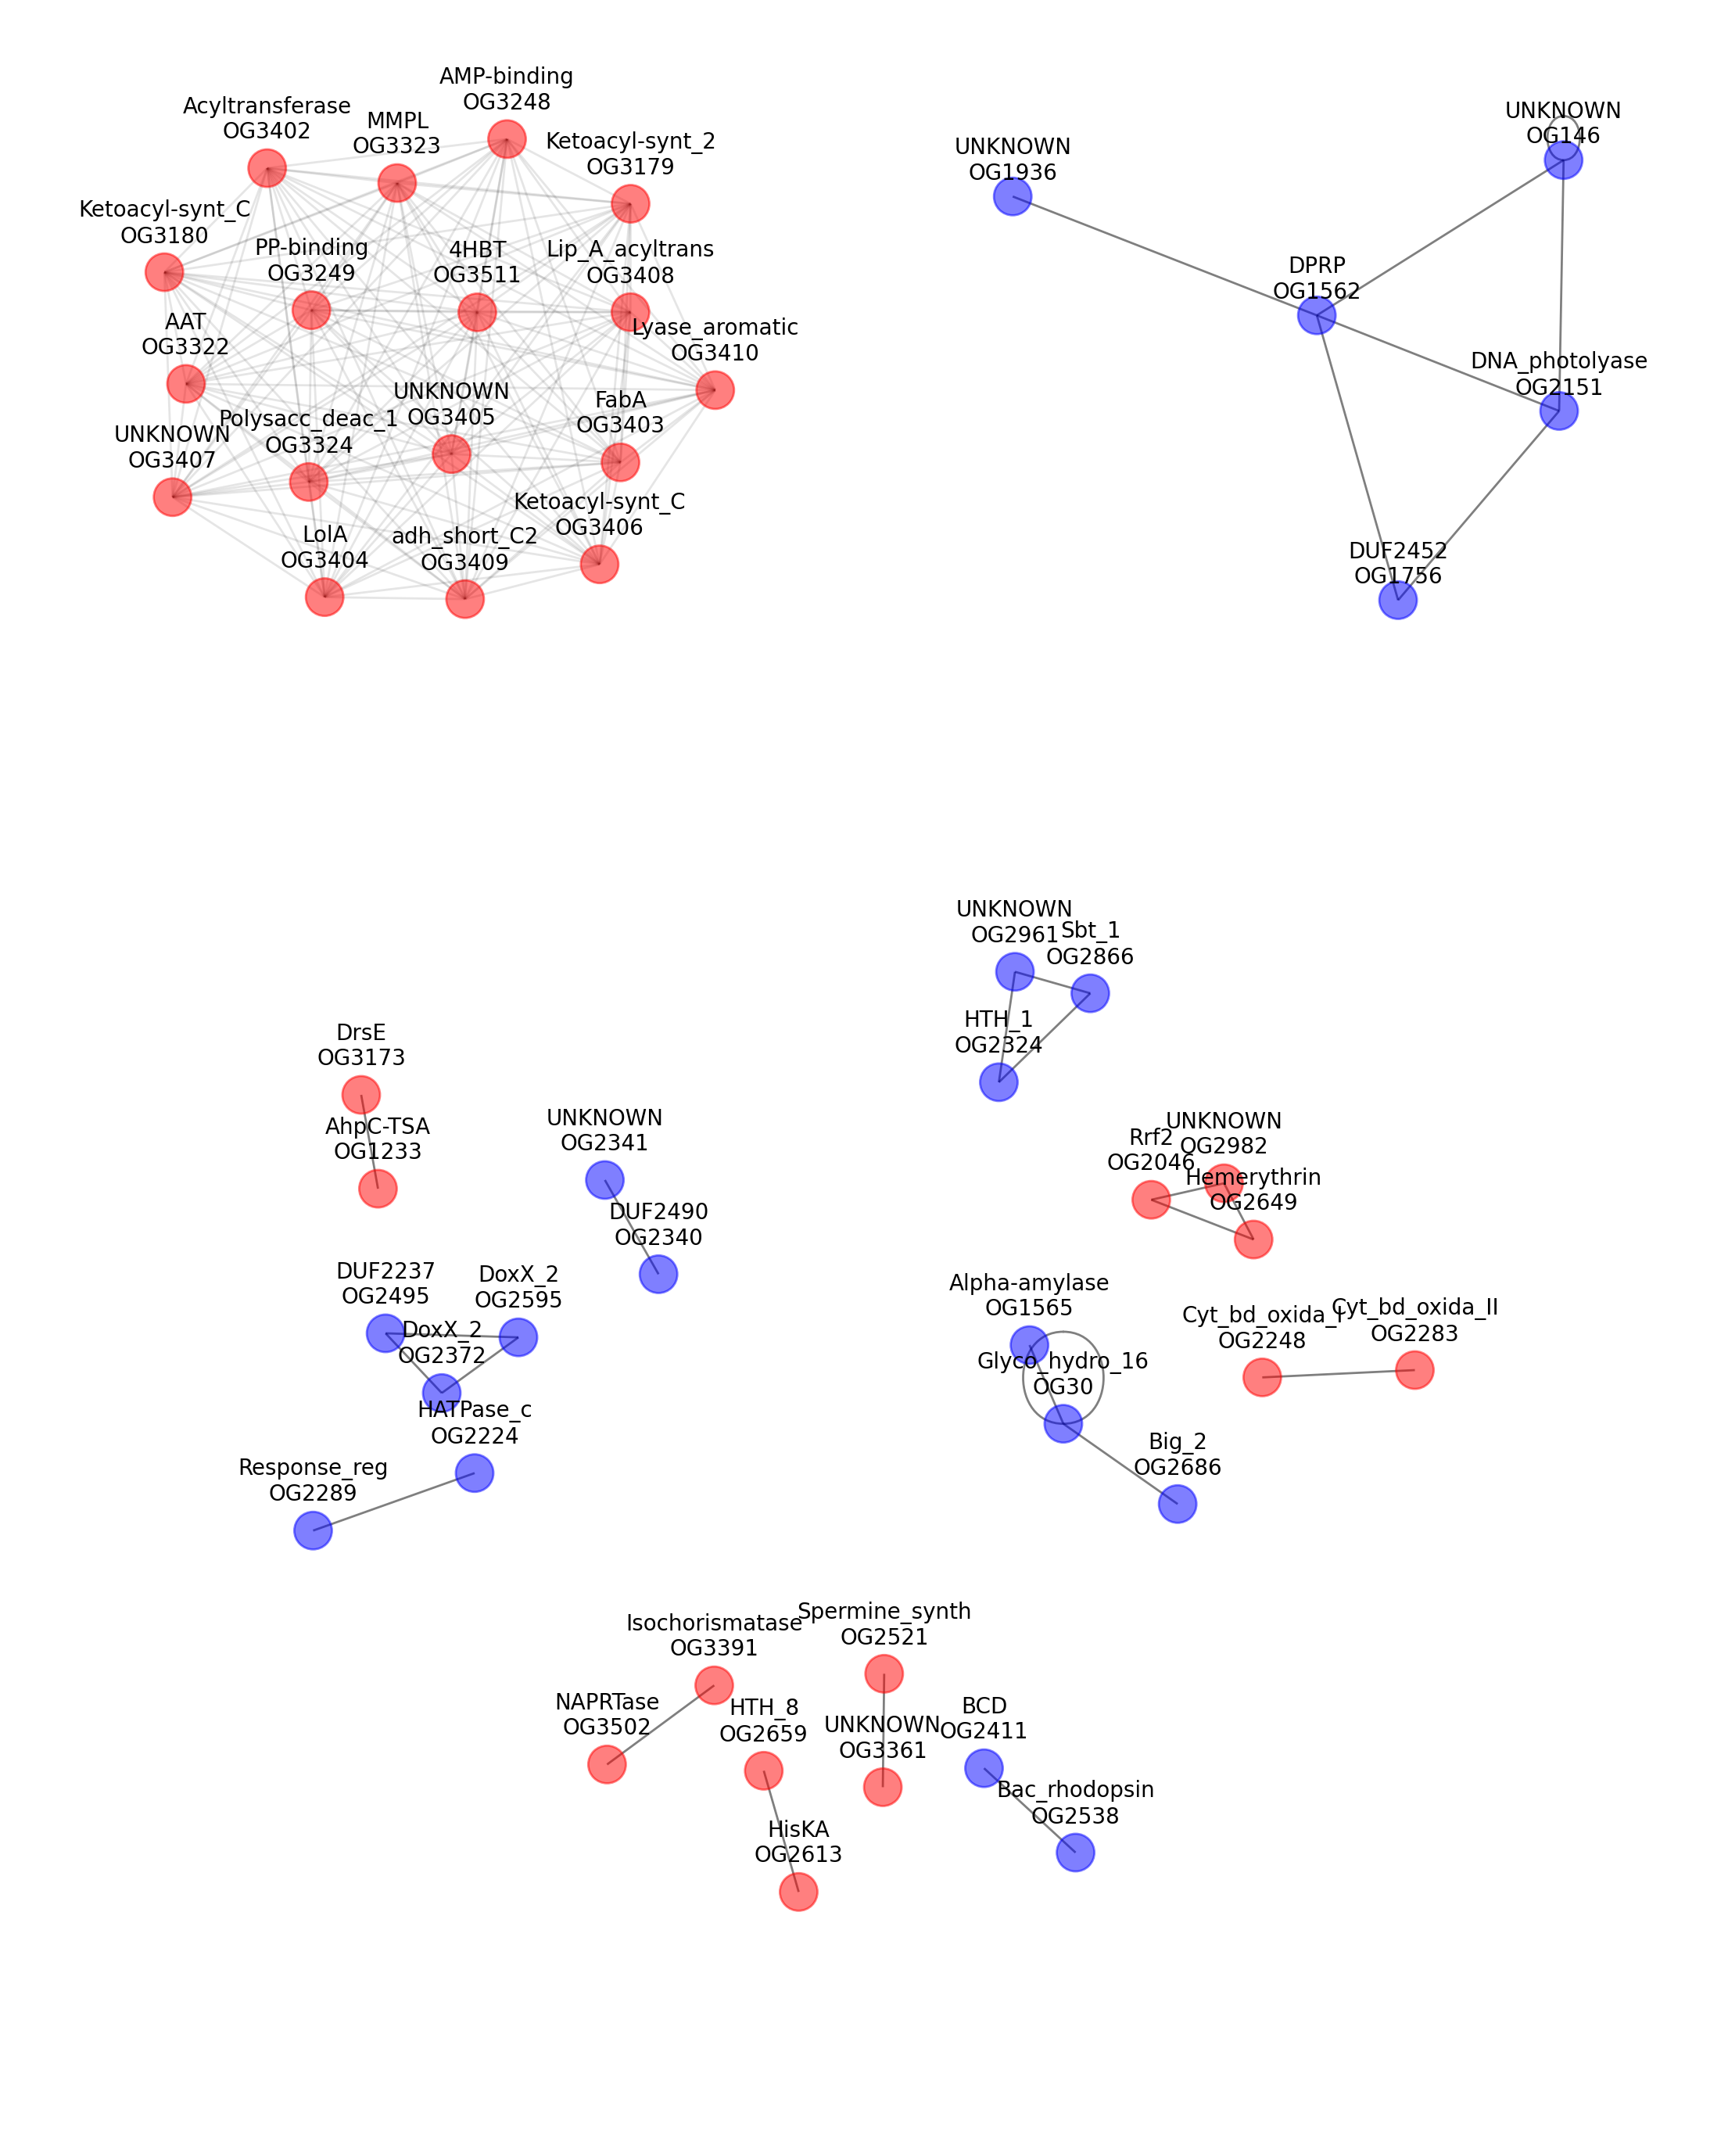

In [18]:
# ネットワークを描画するために隣接リストを作成する
links = {} # 近傍なOGペア -> 出現回数のdict
for key, value in cluster_set.items():
    for cluster in value:
        synteny = [ key + '_' + str(num) for num in cluster]
        for pair in combinations(synteny, 2):
            og1 = seq_og[pair[0]]
            og2 = seq_og[pair[1]]
            og_pair = tuple(sorted([og1, og2]))
            links.setdefault(og_pair, 0)
            links[og_pair] += 1

adjacency = [ [pair[0], pair[1]] for pair in links.keys() 
             if links[pair] >= 10 ]
graph = nx.Graph(adjacency)

# nodeにtextを付与する
attrs = {} # node -> OGの情報
for node in graph.nodes:
    try:
        attrs[node] = {"OG": str(node), "annot":og_pfam[node], "label":f"{og_pfam[node]}\nOG{str(node)}"}
    except KeyError:
        try:
            attrs[node] = {"OG": str(node), "annot":og_kegg[node], "label":f"{og_kegg[node]}\nOG{str(node)}"}
        except KeyError:
            attrs[node] = {"OG": str(node), "annot":"UNKNOWN", "label":f"UNKNOWN\nOG{str(node)}"}

nx.set_node_attributes(graph, attrs)

nx.set_node_attributes(graph, attrs)

print("Largest connected component:",max([len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]))

# 全体のネットワークから連結成分の多い順にサブグラフを並び替えたlistを作成
subgraph = sorted([graph.subgraph(component).copy() for component in nx.connected_components(graph)], key=len, reverse=True)

# 画像全体のサイズを指定(縦, 横)
figure = plt.figure(figsize=(14, 18), dpi = 200)
gs_master = GridSpec(nrows=3, ncols=2, height_ratios=[1, 1, 1], hspace=0, wspace=0)

gs_1 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0, 0])
axes_1 = figure.add_subplot(gs_1[:, :])
g = subgraph[0]

pos=nx.spring_layout(g, seed=20)
nx.draw_networkx_edges(g, pos, alpha=0.1)
nx.draw_networkx_nodes(g, pos, node_color=["red" if biased[int(graph.nodes[node]["OG"])] == "-" else "blue" for node in g.nodes()], alpha=0.5)
pos_higher = {}
y_off = 0.2 # y軸の補正値
for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(g, pos_higher, labels = {int(node): graph.nodes[node]["label"] for node in g.nodes()}, font_size=10)
plt.margins(x=0.2, y=0.2)
plt.axis("off")

gs_2 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0, 1])
axes_2 = figure.add_subplot(gs_2[:, :])
g = subgraph[1]
pos=nx.spring_layout(g)
nx.draw_networkx_edges(g, pos, alpha=0.5)
nx.draw_networkx_nodes(g, pos, node_color=["red" if biased[int(graph.nodes[node]["OG"])] == "-" else "blue" for node in g.nodes()], alpha=0.5)
pos_higher = {}
y_off = 0.1 # y軸の補正値
for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(g, pos_higher, labels = {int(node): graph.nodes[node]["label"] for node in g.nodes()}, font_size=10)
plt.margins(x=0.2, y=0.2)
plt.axis("off")

gs_3 = GridSpecFromSubplotSpec(nrows=2, ncols=2, subplot_spec=gs_master[1:, :])
axes_3 = figure.add_subplot(gs_3[:, :])
G = subgraph[2:]
g = nx.disjoint_union_all(G)
pos=nx.spring_layout(g, k=0.2, iterations=15, seed=0)
nx.draw_networkx_edges(g, pos, alpha=0.5)
nx.draw_networkx_nodes(g, pos, node_color=["red" if biased[int(graph.nodes[int(g.nodes[node] ["OG"])]["OG"])] == "-" else "blue" for node in g.nodes()], alpha=0.5)
pos_higher = {}
y_off = 0.1 # y軸の補正値
for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(g, pos_higher, labels = {int(node): graph.nodes[int(g.nodes[node] ["OG"])]["label"] for node in g.nodes()}, font_size=10)
plt.margins(x=0.2, y=0.2)
plt.axis("off")

plt.show()

##### 入力13-27


In [19]:
# ロドプシンの有無で背景色を変える
with open('tree_color_body.txt', encoding='utf-8', mode='w') as outfile:
    outfile.write('\n')
    for key, value in genome_dict.items():
        if key + '.faa' in rh_plus:
            outfile.write(value + ' range #ccef7c Rh+ 2' + '\n')
        else:
            outfile.write(value + ' range #a1cdee Rh- 2' + '\n')

##### 入力13-28

In [20]:
%%bash
cat microbiome_suppl/tree_color_template.txt tree_color_body.txt > tree_color.txt

##### 入力13-29

In [21]:
df_itol = count_table.loc[[2538, 3953, # rhodopsin 
                           2151, 1936, 146, 1562, 1756, # photolyase
                           3402, 3179, 3180, 3404, 3403 # APE
                           ]].T
with open('tree_binary_body.txt', encoding='utf-8', mode='w') as outfile:
    outfile.write('\n')
    for i, row in df_itol.iterrows():
        tmp = []
        genome = genome_dict[i.replace('.faa', '')]
        tmp.append(genome)
        for num in row:
            if num >= 1:
                tmp.append('1')
            else:
                tmp.append('0')
        outfile.write(','.join(tmp) + '\n')
   

##### 入力13-30


In [22]:
%%bash
cat microbiome_suppl/tree_binary_template.txt tree_binary_body.txt > tree_binary.txt